# Ethiopia cereals crop model using Gro API
A simple crop model using data in Gro for five crops (Corn, Wheat, Barley, Sorghum and Millet). The accompanying Gro web app display for [ET-KE-SO Cereals](https://app.gro-intelligence.com/displays/wZRlaQb9B) provides an overview of the data series we will use. The goal is to have a robust model that can be used on day of the year to forecast end of year yield.

## Preliminary

In [5]:
import logging
import os
import warnings
from api.client.crop_model import CropModel
    
warnings.filterwarnings('ignore')

countries = ["Ethiopia"]
crops = ["Corn", "Wheat", "Barley", "Sorghum", "Small millet"]
model = CropModel('api.gro-intelligence.com', os.environ['GROAPI_TOKEN'])

##  Historical yields
To get data series for national level yields, we set the entities (item, metric and region), and 
find available data series.  Note that there are  a few different <em>sources</em>, e.g. 
[FAO](https://app.gro-intelligence.com/dictionary/sources/2), 
[PS&D](https://app.gro-intelligence.com/dictionary/sources/14), 
[IGC](https://app.gro-intelligence.com/dictionary/sources/19).  Each source covers a slightly different time range. Note that one source, PS&D, uses market-years that go from July to June, while the other two use calendar years. All differ from each other to some extend in the reported yields.  Here we simply take all of them as training data, i.e we effectively weight them equally as estimates or samples of the "ground truth". 

In [6]:
TONNES_PER_HECTARE_UNIT_ID = 61

for country in countries:
    for crop in crops:
        for yield_series in model.find_data_series(region=country, item=crop, metric="yield mass/area"):
            yield_series['unit_id'] = TONNES_PER_HECTARE_UNIT_ID
            model.add_single_data_series(yield_series)

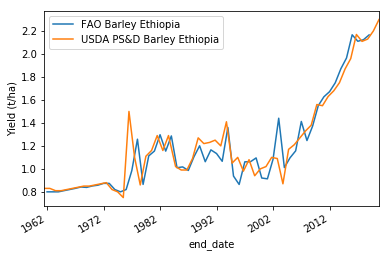

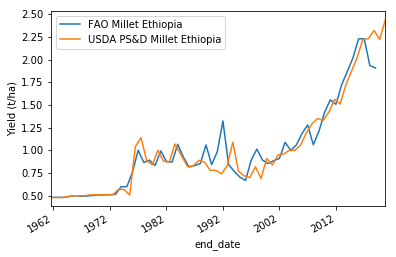

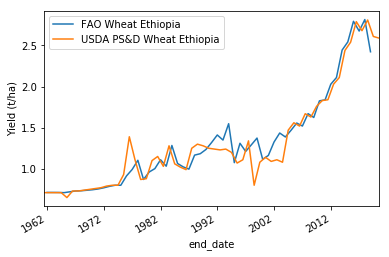

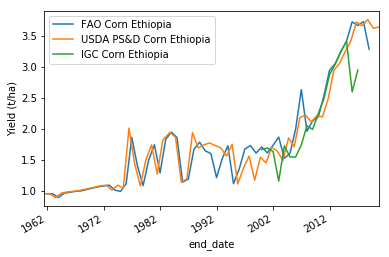

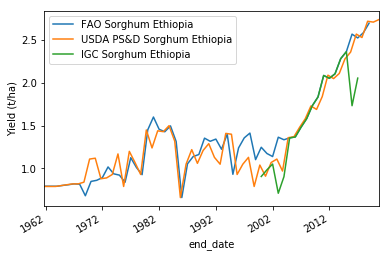

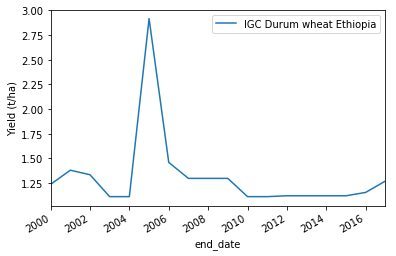

In [97]:
%matplotlib inline
import pandas
import matplotlib.pyplot as plt

df = model.get_df()
yield_metric_id = model.search_for_entity("metrics", "yield mass/area")

for item_id, yield_df in df.loc[df.metric_id == yield_metric_id].groupby(['item_id']):
    fig, axes = plt.subplots(1, 1)
    for (source_id, region_id), group in yield_df.groupby(['source_id', 'region_id']):
        group.plot(x='end_date', y='value', ax=axes, x_compat=True,
                   label="{} {} {}".format(model.lookup('sources', source_id)['name'], 
                                           model.lookup('items', item_id)['name'],
                                           model.lookup('regions', region_id)['name']))
    plt.ylabel("Yield (t/ha)")
    plt.show()

##  Detrend yields

Compute the yield trends over the last 20 years and subtract

Barley


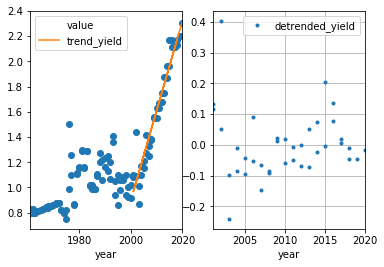

Millet


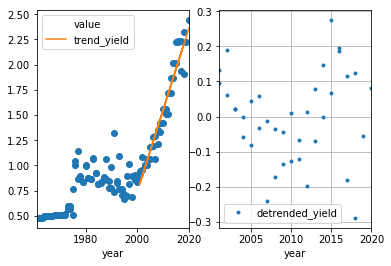

Wheat


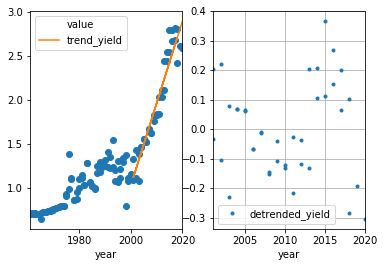

Corn


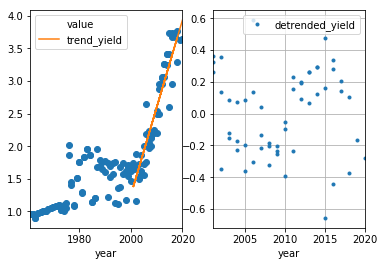

Sorghum


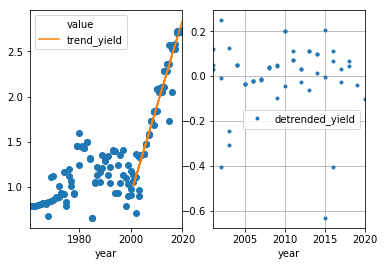

Durum wheat


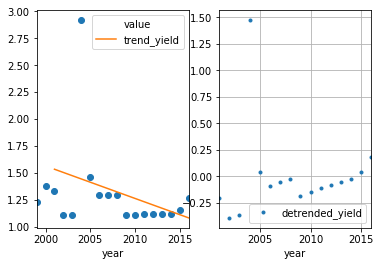

In [98]:
from sklearn import linear_model

TREND_START_YEAR = 2000
df = model.get_df()
dy_df = {}
trends = {}

for item_id, XY in df.loc[df.metric_id == yield_metric_id].groupby(['item_id']):
    crop = model.lookup('items', item_id)['name']
    print(crop)
    # Compute trend
    trend = linear_model.LinearRegression()
    XY['year'] = XY.end_date.map(lambda x: x.year)
    X = XY.loc[XY.year > TREND_START_YEAR].loc[:, ['year']]
    Y = XY.loc[XY.year > TREND_START_YEAR]['value']
    trend.fit(X, Y)
    trends[crop] = trend
    lm_df = pandas.DataFrame([{'year': year, 'trend_yield': value}
                             for (year, value) in zip(X['year'], trend.predict(X))])
    # De-trend
    dy = pandas.DataFrame([{'year': year, 'detrended_yield': value}
                             for (year, value) in zip(
                                XY.loc[XY.year > TREND_START_YEAR]['year'], 
                                XY.loc[XY.year > TREND_START_YEAR].apply(lambda row: row.value - trend.predict([[row.year]])[0], axis=1))
                                                      ])
    dy_df[crop] = dy
    
    # Plot
    fig, axes = plt.subplots(1, 2)
    XY.plot(x='year', y='value', marker='o', linestyle='', ax=axes[0])
    lm_df.plot(x='year', y='trend_yield',  ax=axes[0])
    dy.plot(x='year', y='detrended_yield', marker='.', linestyle='', ax=axes[1])
    plt.grid(b=True, which='both')
    plt.show()

## Per crop land cover area as  "weight" 
We compute the "weight" of each region, based on the land area covered by cereals. First we get the regions.

In [60]:
REGION_LEVEL_ID = 5
regions = []

for country in countries:
    country_id = model.search_for_entity('regions', country)
    for region in model.get_descendant_regions(country_id, REGION_LEVEL_ID):    
        regions.append(region)

region_ids = [region['id'] for region in regions]
print("{} regions".format(len(regions)))

98 regions


Then we inspect their weights. This step can be skipped as we will automatically recompute the weights when using them.

In [62]:
import numpy

weights = {}

for crop in crops:
    print(crop)
    w = model.compute_weights(crop, "land cover area", regions)
    if not w:
        continue
    weights[crop] = pandas.DataFrame([{'region': region['name'], 'weight': wr} for (region, wr) in zip(regions, w)])
    print(weights[crop])

Corn
                    region        weight
0                  Unknown           NaN
1                   Zone 1           NaN
2                   Zone 2           NaN
3                   Zone 3           NaN
4                   Zone 4           NaN
5                   Zone 5           NaN
6                   Zone 6           NaN
7            Awsi (Zone 1)  4.162649e-03
8         Kilbati (Zone 2)  3.248067e-06
9            Gabi (Zone 3)  7.275291e-04
10          Fenti (Zone 4)  3.402236e-06
11           Hari (Zone 5)  1.514920e-04
12                     Awi           NaN
13  Bahir Dar Special Zone  2.883514e-05
14              East Gojam  2.866524e-02
15            North Gonder  2.952758e-02
16        North Shewa (R3)  9.114687e-03
17             North Wollo  2.866076e-03
18                  Oromia  1.518225e-03
19            South Gonder  2.236299e-02
20             South Wollo  7.238951e-03
21               Wag Himra  8.365101e-04
22              West Gojam  8.625372e-02
23         

                    region        weight
0                  Unknown           NaN
1                   Zone 1           NaN
2                   Zone 2           NaN
3                   Zone 3           NaN
4                   Zone 4           NaN
5                   Zone 5           NaN
6                   Zone 6           NaN
7            Awsi (Zone 1)  0.000000e+00
8         Kilbati (Zone 2)  7.754272e-07
9            Gabi (Zone 3)  4.726187e-07
10          Fenti (Zone 4)  1.303482e-05
11           Hari (Zone 5)  0.000000e+00
12                     Awi           NaN
13  Bahir Dar Special Zone  8.709030e-05
14              East Gojam  9.310646e-03
15            North Gonder  1.088386e-01
16        North Shewa (R3)  2.588615e-04
17             North Wollo  2.463935e-03
18                  Oromia  2.101796e-04
19            South Gonder  8.613319e-02
20             South Wollo  5.754186e-03
21               Wag Himra  9.310203e-04
22              West Gojam  1.519099e-01
23              

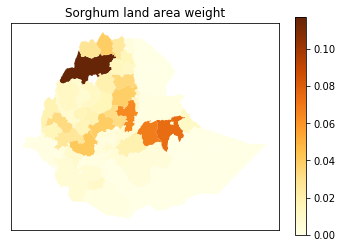

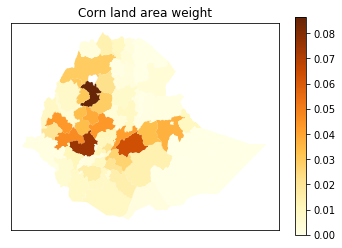

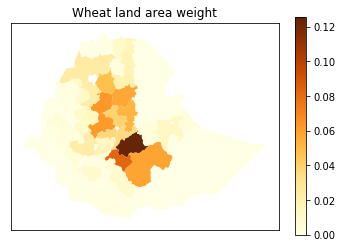

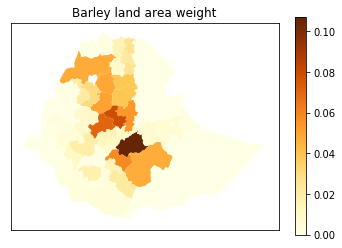

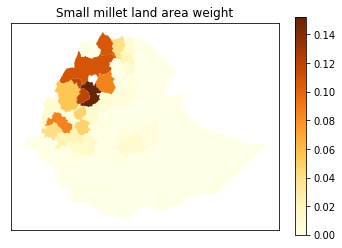

In [63]:
import geopandas
from shapely.geometry import shape

for crop in weights:
    shapes = []
    for (region, weight) in zip(regions, weights[crop].weight):
        geojson = model.get_geojson(region['id'])
        if not geojson:
            continue
        shapes.append(
            { 'region_id': region['id'], 
              'geometry': shape(geojson['geometries'][0]),
              'crop_weight': weight if weight > 0 else 0
            }) 
    gdf = geopandas.GeoDataFrame(shapes)
    gdf.set_index('region_id')
    fig, axes = plt.subplots(1, 1)
    gdf.plot(column='crop_weight', 
         cmap='YlOrBr', ax=axes, vmin=0, vmax=weights[crop].weight.max(), legend=True)
    axes.set_title('{} land area weight'.format(crop))
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    plt.show()

## NDVI

In [67]:
cw_ndvi_dfs = {}

for crop in crops:
    print(crop)
    cw_ndvi_dfs[crop] = model.compute_crop_weighted_series(
        crop, 'land cover area',
        'Vegetation NDVI', 'Vegetation Indices', regions)

Corn


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

Wheat


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

Barley


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

Sorghum


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

Small millet


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

In [68]:
def show_series(fdf, item_name, metric_name, 
                 eval_start_date, cmap='Greens', vmin=None, vmax=None):
    """Plot choropleth map of the series on the given date, and time series for each region."""
    item_id = model.search_for_entity("items", item_name)
    metric_id = model.search_for_entity("metrics", metric_name)
    print(item_id, metric_id)
    df1 = fdf.loc[(fdf.item_id == item_id) & (fdf.metric_id == metric_id) & (fdf.start_date == eval_start_date),:]
    gdf1 = gdf.join(df1.set_index('region_id'), on='region_id')
    fig, axes = plt.subplots(1, 1)
    gdf1.plot(column='value', cmap=cmap, ax=axes, vmin=vmin, vmax=vmax, legend=True)
    axes.set_title('{} {}'.format(item_name, metric_name))
    fig, axes = plt.subplots(1, 1, figsize=(12,8))
    for region_id, group in fdf.loc[
        (fdf.item_id == item_id) & (fdf.metric_id == metric_id)].groupby(['region_id']):
        if not group['value'].dropna().size:
            continue
        group.plot(x='end_date', y='value', ax=axes, legend=False) # label=model.lookup('regions', region_id)['name'])
        plt.grid(b=True, which='both')
    plt.show()

Corn
(321, 70029)


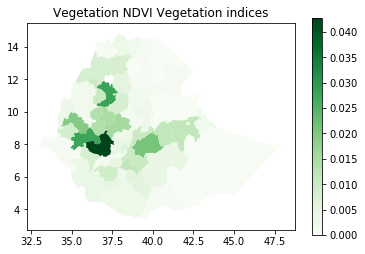

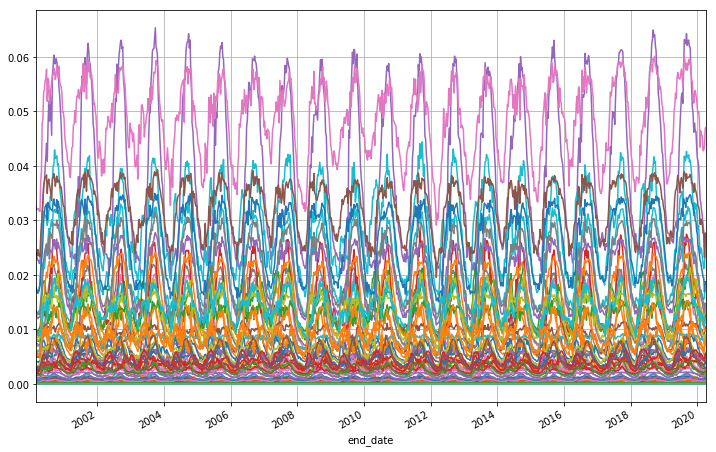

Wheat
(321, 70029)


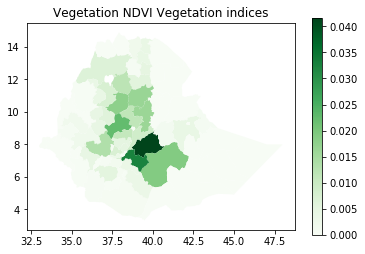

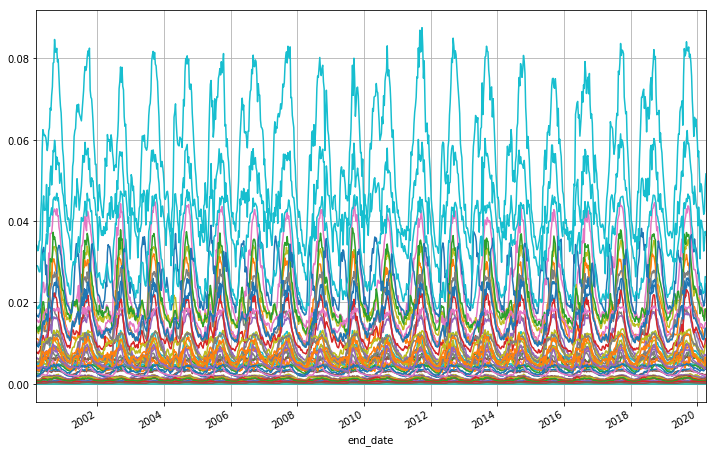

Barley
(321, 70029)


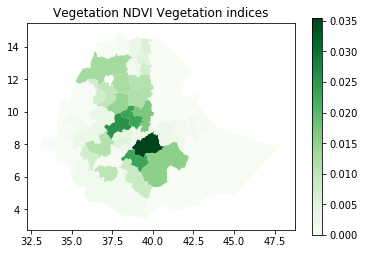

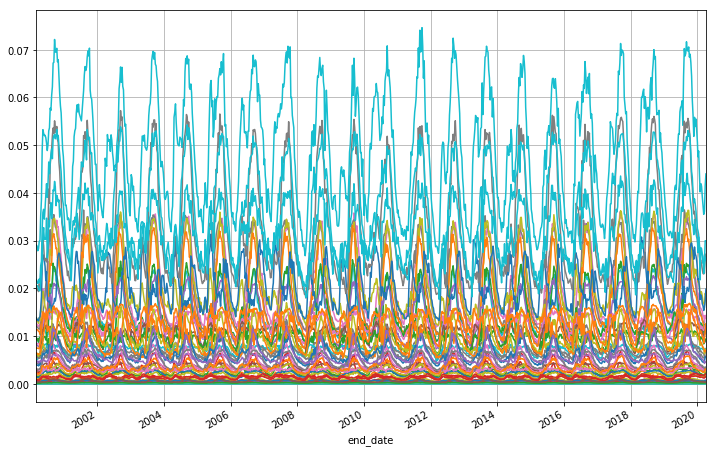

Sorghum
(321, 70029)


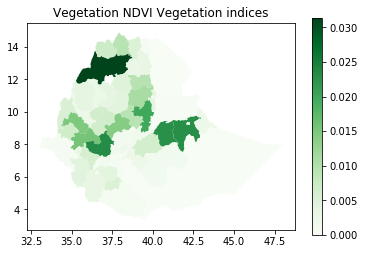

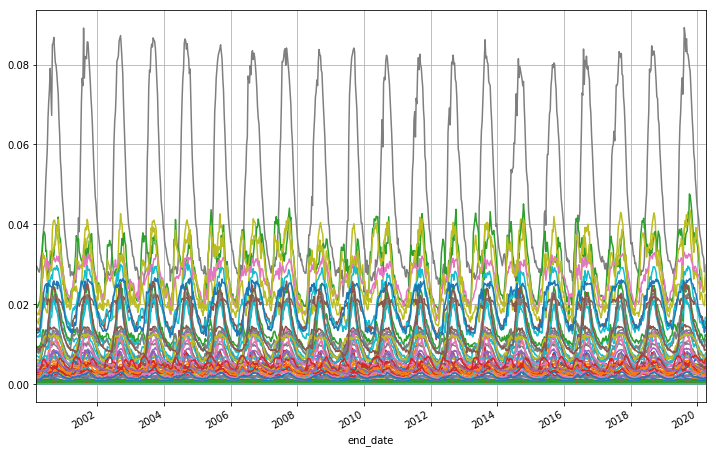

Small millet
(321, 70029)


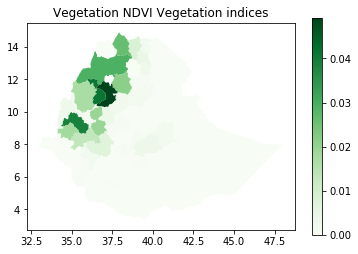

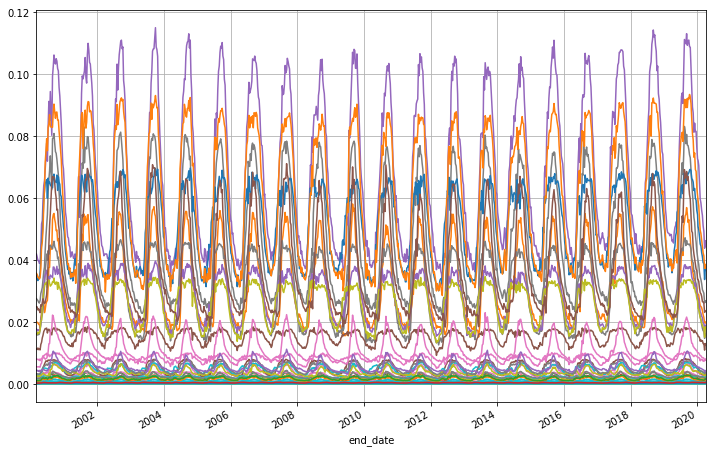

In [69]:
for crop in crops:
    print(crop)
    show_series(cw_ndvi_dfs[crop], "Vegetation NDVI", "Vegetation indices", u'2020-03-05', 'Greens')

## Evapotranspiration

In [70]:
cw_et_dfs = {}

for crop in crops:
    print(crop)
    cw_et_dfs[crop] = model.compute_crop_weighted_series(
        crop, 'land cover area',
        'Evapotranspiration', 'Evapotranspiration value', regions)

Corn
Wheat
Barley
Sorghum
Small millet


Corn
(4395, 4660031)


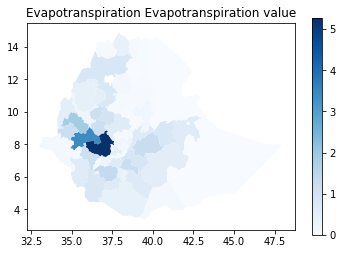

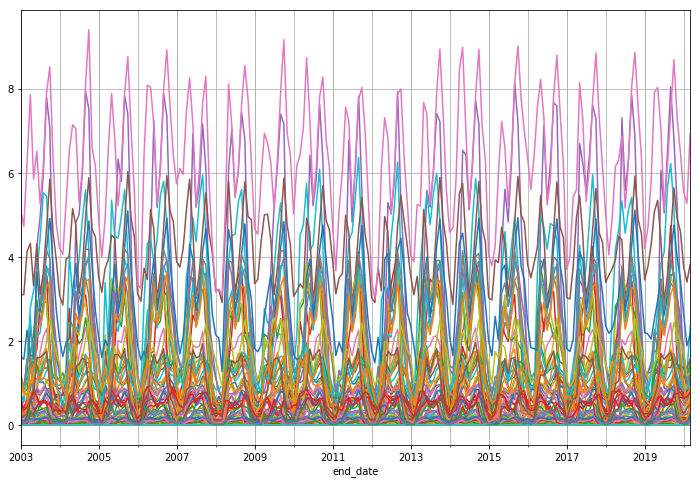

Wheat
(4395, 4660031)


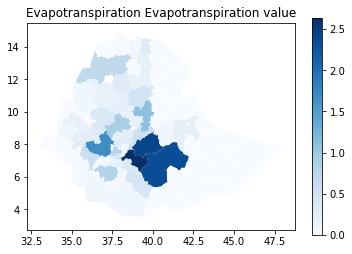

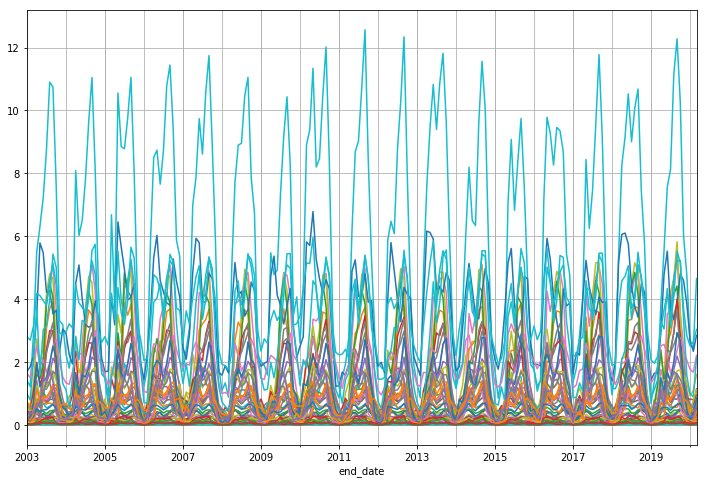

Barley
(4395, 4660031)


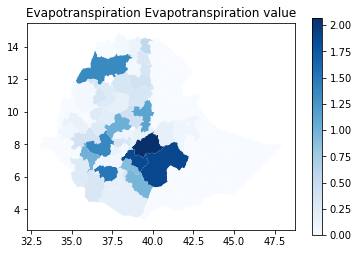

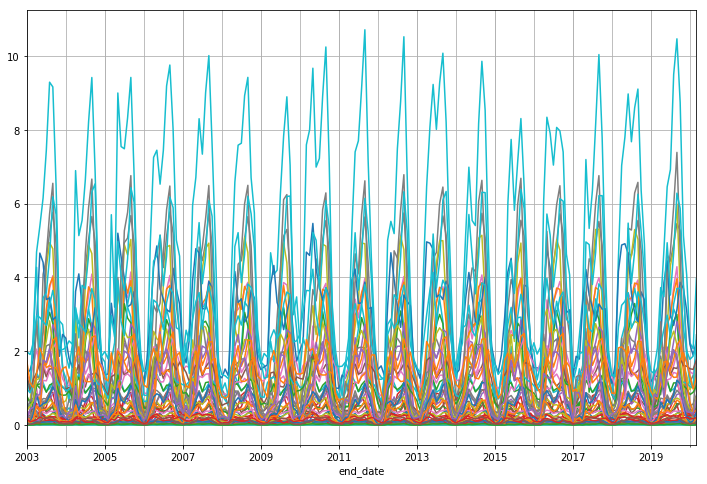

Sorghum
(4395, 4660031)


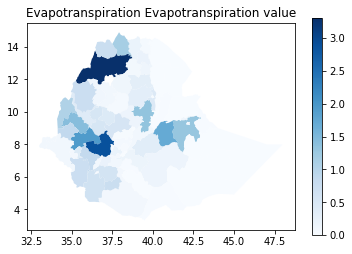

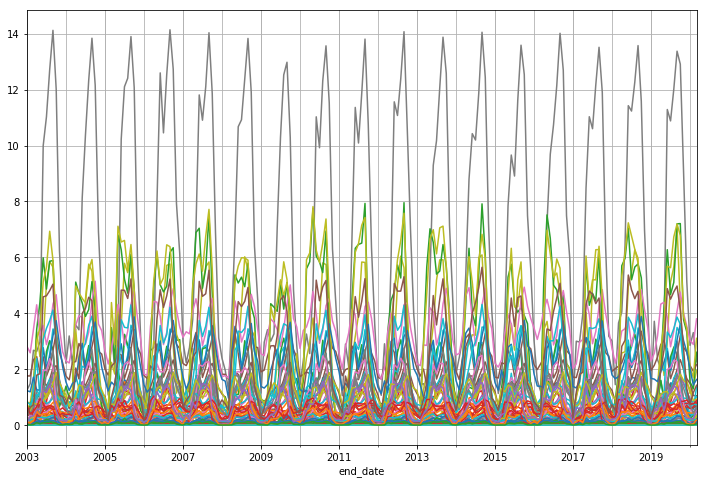

Small millet
(4395, 4660031)


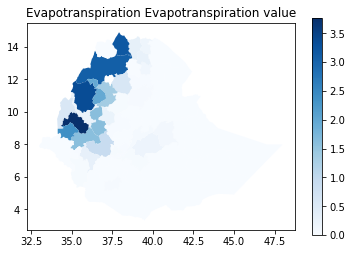

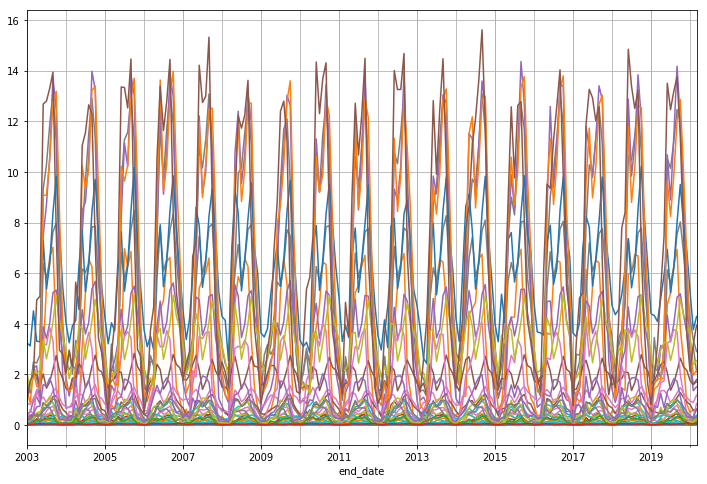

In [71]:
for crop in crops:
    print(crop)
    show_series(cw_et_dfs[crop], "Evapotranspiration", "Evapotranspiration value", '2020-02-01', 'Blues')

## ET anomaly
Now let's look at [evapotranspiration](https://app.gro-intelligence.com/dictionary/items/4395) [anomaly](https://app.gro-intelligence.com/dictionary/metrics/15852239).

In [72]:
cw_eta_dfs = {}

for crop in crops:
    print(crop)
    cw_eta_dfs[crop] = model.compute_crop_weighted_series(
        crop, 'land cover area',
        'Evapotranspiration', 'Evapotranspiration difference from 10-yr median (2003-2013)',
        regions, lambda w,v: w*(v-100.0))

Corn


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

Wheat


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

Barley


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

Sorghum


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

Small millet


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

Examine on a particular date, first ET anomaly and then ET anomaly normalized and weigthed by crop land.

Corn
(4395, 15852239)


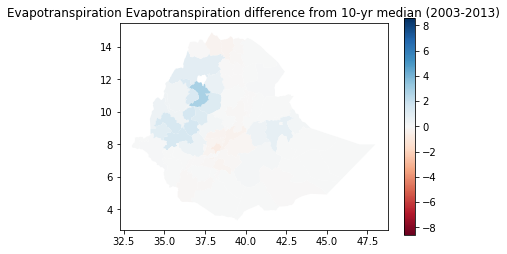

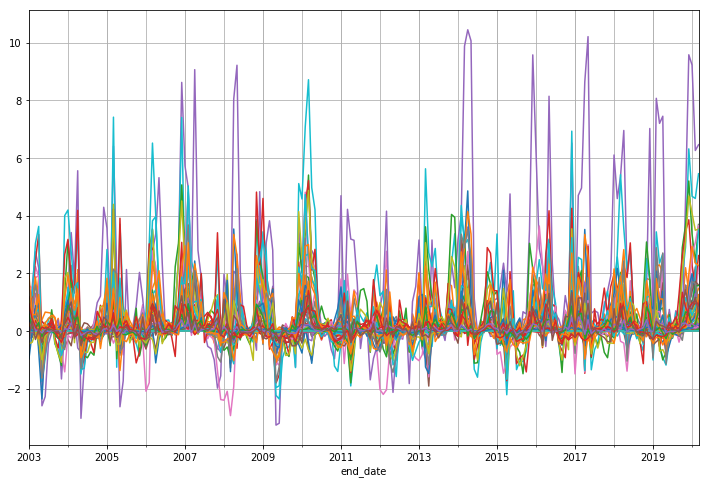

Wheat
(4395, 15852239)


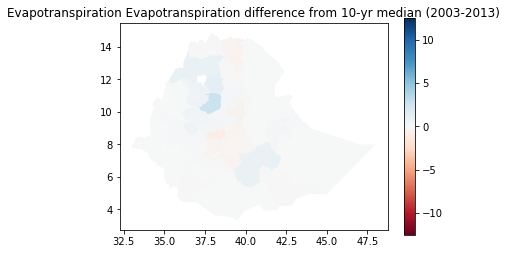

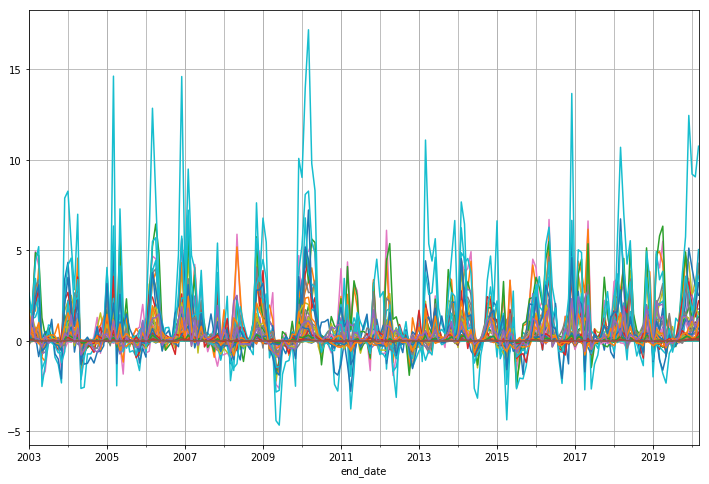

Barley
(4395, 15852239)


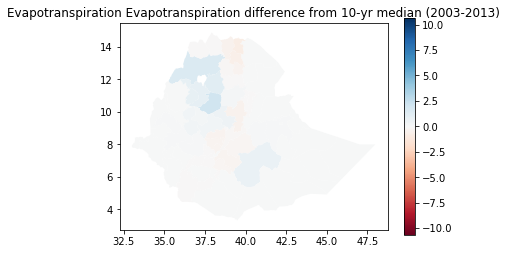

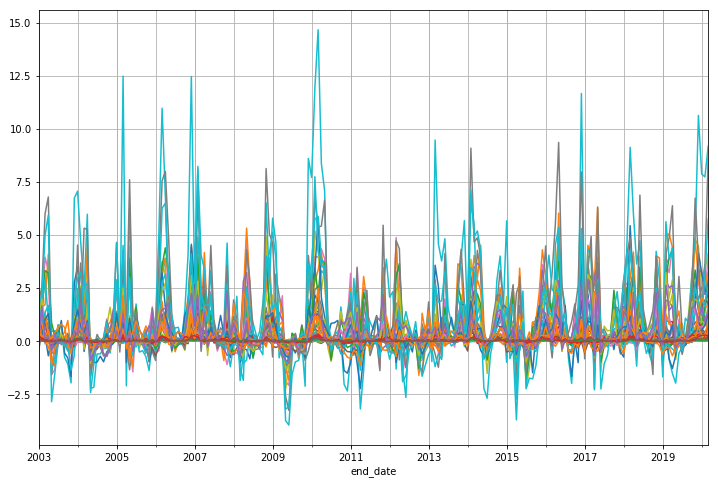

Sorghum
(4395, 15852239)


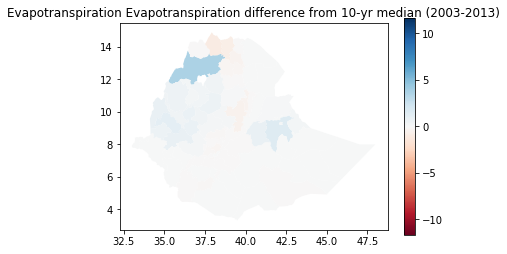

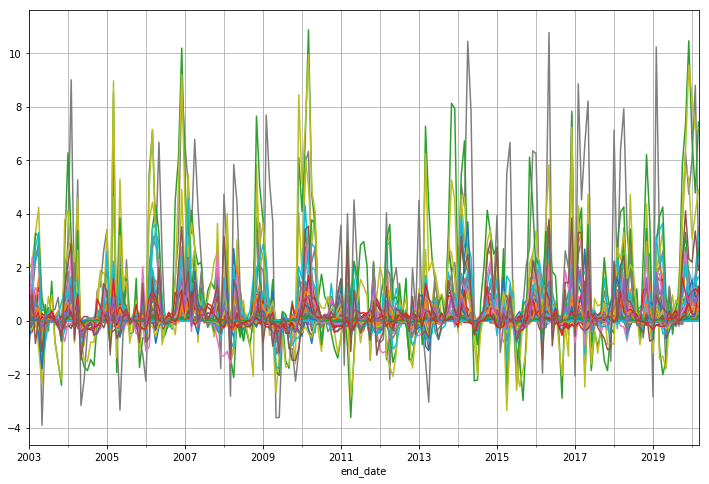

Small millet
(4395, 15852239)


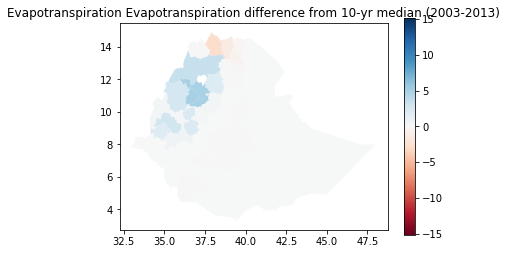

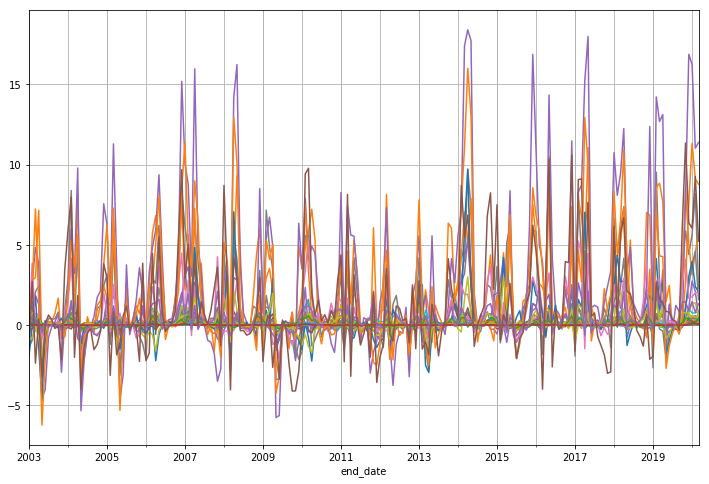

In [73]:
for crop in crops:
    print(crop)
    amp = weights[crop].weight.max()
    show_series(cw_eta_dfs[crop], 
                 "Evapotranspiration", 
                 "Evapotranspiration difference from 10-yr median (2003-2013)", 
                 '2009-04-01', 'RdBu',vmin=-100*amp, vmax=100.0*amp)

By inspecting a few extreme years, e.g. 2009, it seems like May evapotranspiration anomalies are a strong indicator of yield.  But February, March, April are not.

## Rainfall

In [74]:
cw_rf_dfs = {}

for crop in crops:
    print(crop)
    cw_rf_dfs[crop] = model.compute_crop_weighted_series(
        crop, 'land cover area',
        'Rainfall', 'Precipitation difference from 10-yr mean (2001-2010)',
        regions)

Corn


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

Wheat


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

Barley


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

Sorghum


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

Small millet


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

Corn
(2039, 2110131)


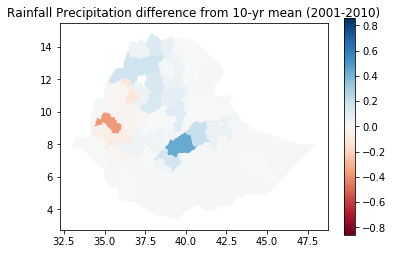

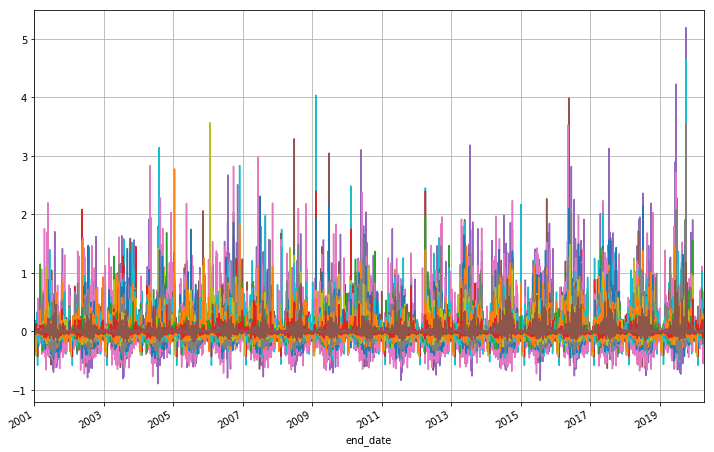

Wheat
(2039, 2110131)


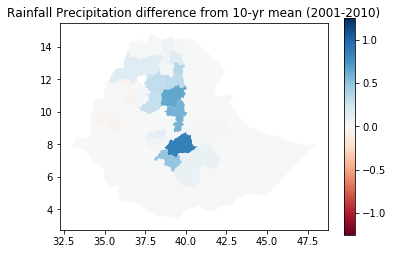

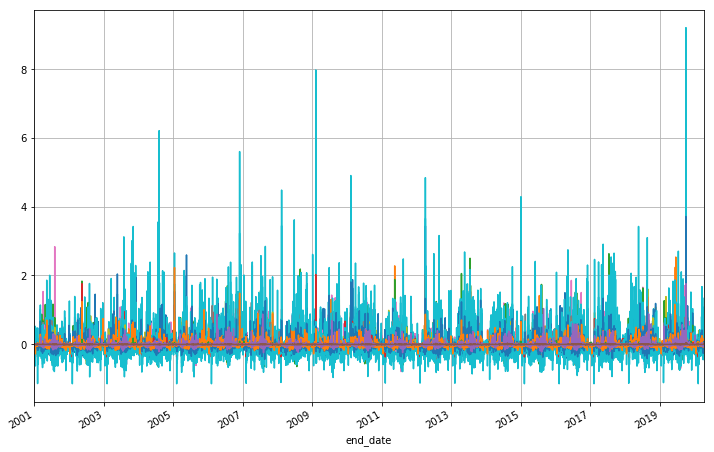

Barley
(2039, 2110131)


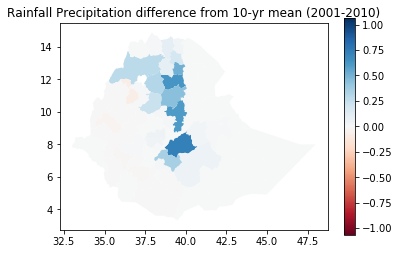

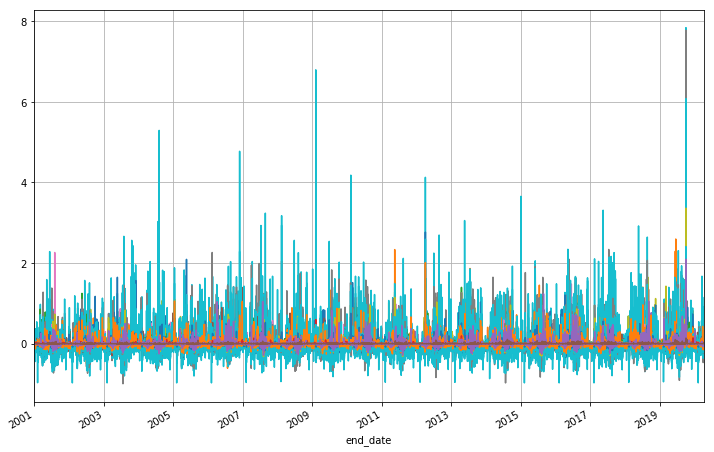

Sorghum
(2039, 2110131)


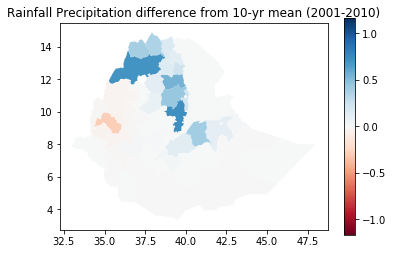

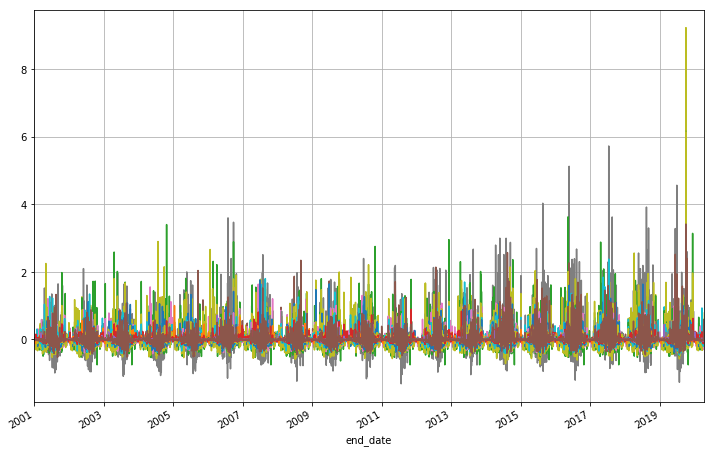

Small millet
(2039, 2110131)


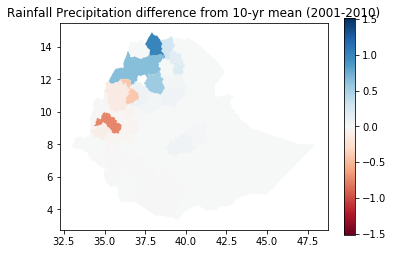

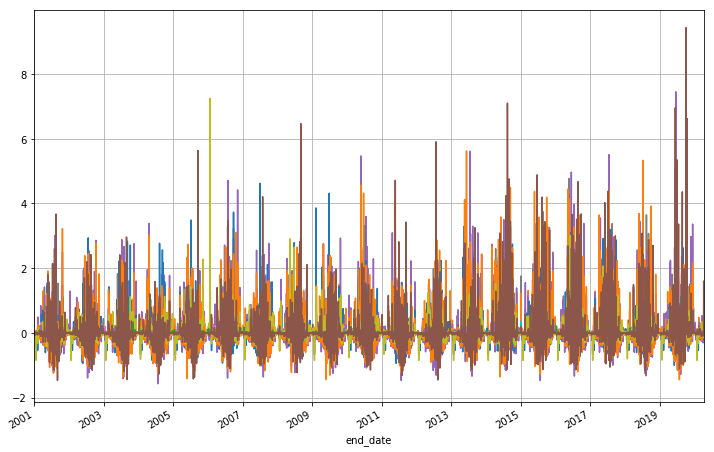

In [75]:
for crop in crops:
    print(crop)
    amp = weights[crop].weight.max()
    show_series(cw_rf_dfs[crop], 
                 "Rainfall", 
                 "Precipitation difference from 10-yr mean (2001-2010)",
                 '2019-07-01', cmap='RdBu',vmin=-10*amp, vmax=10.0*amp)

## Temperature

In [76]:
cw_temp_dfs = {}

for crop in crops:
    print(crop)
    cw_temp_dfs[crop] = model.compute_crop_weighted_series(
        crop, 'land cover area',
        'Land temperature daytime', 'Temperature',
        regions)

Corn


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

Wheat


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

Barley


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

Sorghum


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

Small millet


Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see https://developers.gro-intelligence.com/faq.html
Data series have some historical regions, see http

Corn
(3457, 2540047)


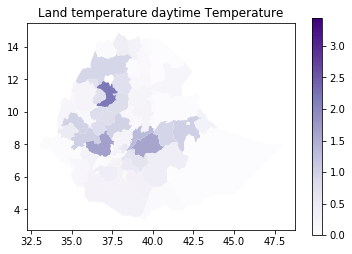

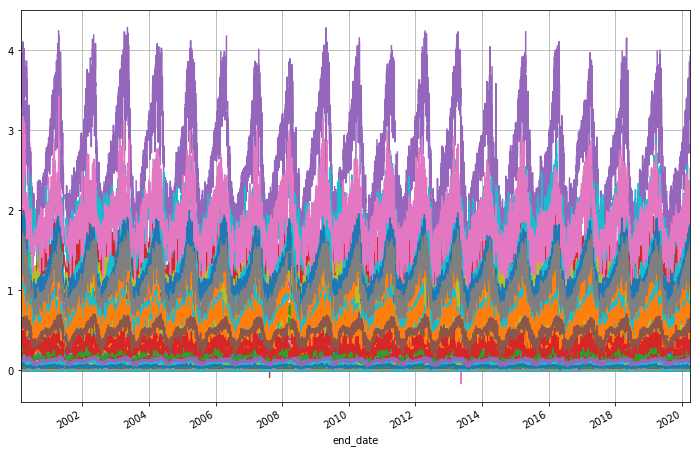

Wheat
(3457, 2540047)


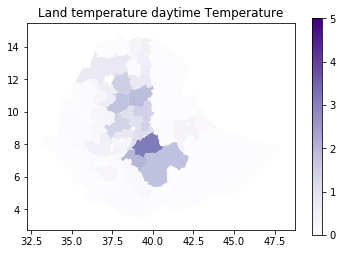

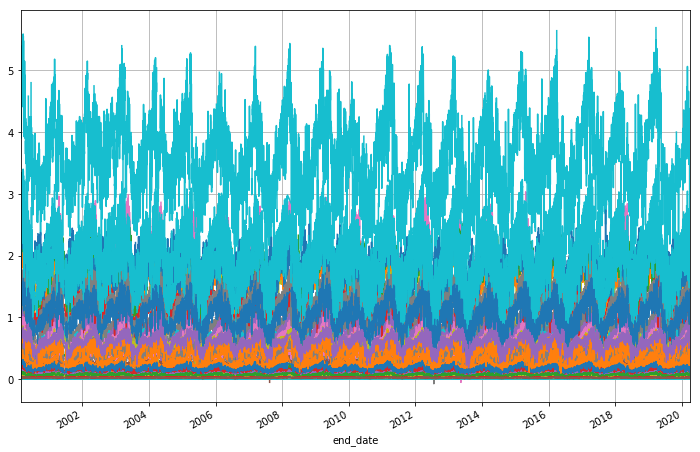

Barley
(3457, 2540047)


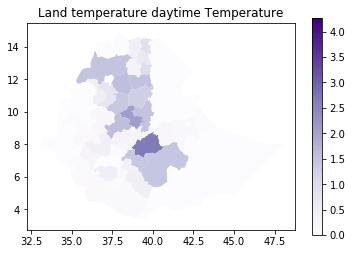

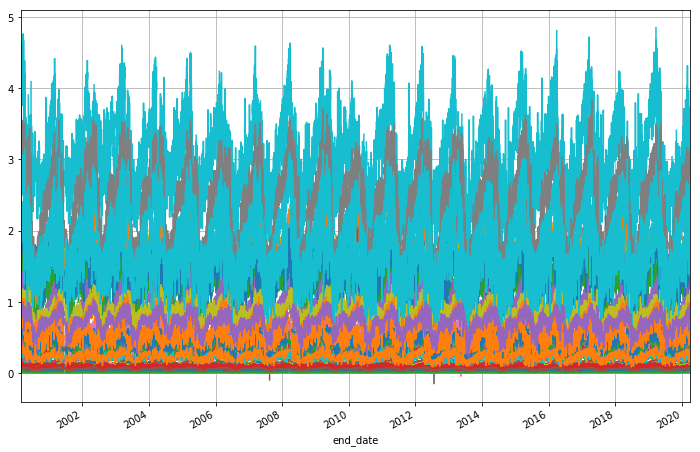

Sorghum
(3457, 2540047)


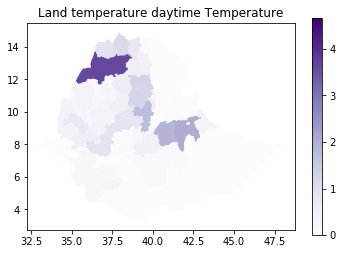

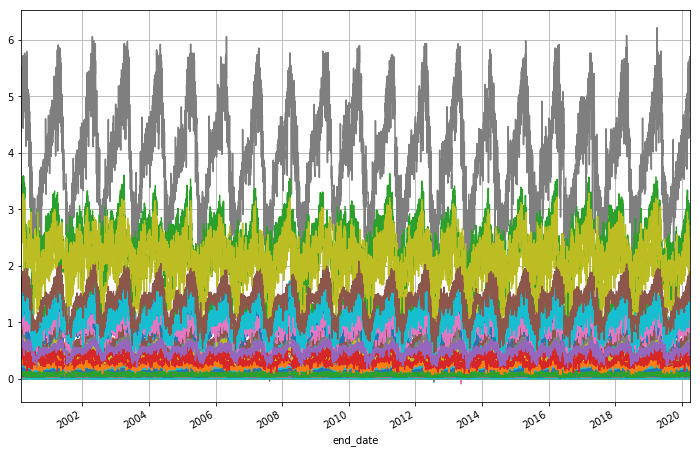

Small millet
(3457, 2540047)


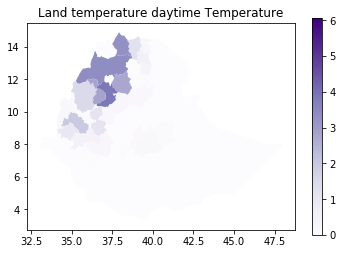

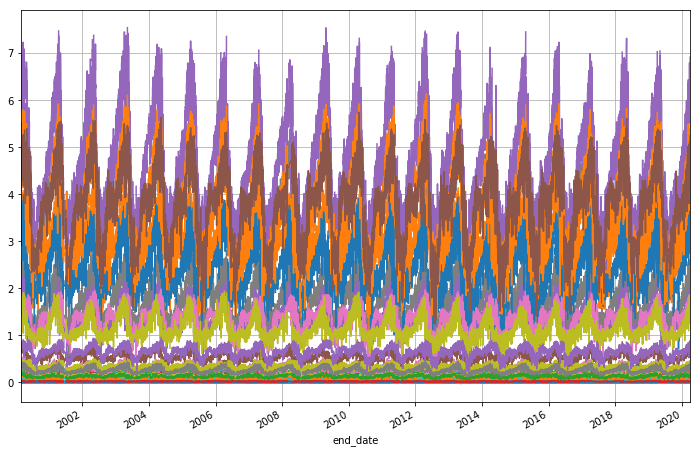

In [77]:
for crop in crops:
    print(crop)
    amp = weights[crop].weight.max()
    show_series(cw_temp_dfs[crop], 
                "Land temperature daytime", 
                "Temperature",
                '2010-07-01',cmap='Purples', vmin=0, vmax=amp*40)

## Relationship between  yield and crop-weighted geospatial feature
In specific parts of the season, we can look at crop weighted geospatial data as predictor of yield for the year. We pick dates based on the crop calendar for this crop on our [display](https://app.gro-intelligence.com/displays/wZRlaQb9B).  We look at historical values of the feature during selected phases of the season, and compare them to the final yields for the same year.

In [ ]:
import numpy

def peak_day(g):
    try:
        index = numpy.nanargmax(g.value)
        v = g.iloc[index].end_date.dayofyear
        return v
    except ValueError:
        return numpy.nan

def avg_td(df):
    return df.value.mean()


def get_feature(cw_df, feature_name, doy, start_doy=None, tol=0, func=avg_td, year=None):
    """A 'feature' is the data series grouped by region, evaluated from start_doy to doy, 
    in each year. func is the evaluation function (average, peak, etc.).
    """
    if not start_doy:
        start_doy = doy
    if year:
        cw_df = cw_df.loc[cw_df.end_date.map(lambda x: x.year == year)]
    
    print('{}, {}-{}'.format(feature_name, start_doy, doy))
    features = []
    
    for region_id, group in cw_df.groupby('region_id'):
            
            def window_in_year(row):
                # apply func() on data from start_doy to row.end_date
                return func(group.loc[group.end_date.map(
                    lambda x: x.year == row.end_date.year \
                              and x.dayofyear >= start_doy \
                              and x.dayofyear <= row.end_date.dayofyear)
                                ])

            tmp = group.loc[group.end_date.map(lambda x: x.dayofyear<=doy and x.dayofyear>doy-tol),:]
            tmp.loc[:, 'value'] = tmp.apply(window_in_year, axis=1)
            features.append(tmp)
    
    feature_df = pandas.concat(features)
    # group by date and sum regions
    return pandas.DataFrame([{'year': end_date.year, feature_name: float(group.value.sum())}
                              for (end_date, group) in  feature_df.groupby(['end_date'])])


def show_feature(x_df, y_df, feature_name):
    """Time series and scatter plot of feature and yield"""
    xy_df = x_df.merge(y_df, on='year', how='outer')
    figs, axes = plt.subplots(1, 3, figsize=(12, 8))
    xy_df.plot(x='year', y=feature_name, marker= 'o', ax=axes[1])
    xy_df.plot(x='year', y='detrended_yield', marker= '.', linestyle='None',ax=axes[0])
    plt.grid(b=True, which='both')
    xy_df.plot.scatter(x=feature_name, y = 'detrended_yield',ax=axes[2])
    plt.grid(b=True, which='both')
    plt.show()

### ET anomaly jun-sep
Evapotranspiration is a key indicator of crop health, when used as a seasonal value.  See e.g. [Tadesse et al](https://www.sciencedirect.com/science/article/pii/S0303243415000604). Thus in each of teh two separate growing periods in the year, we will take cummulative ET anomalies as a feature.  Let's look at the jun-sep period for example.

Corn
Evapotranspiration, 180-275


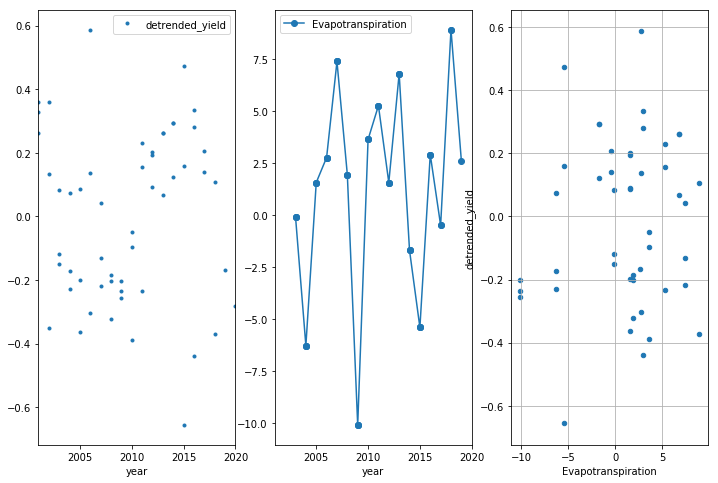

Wheat
Evapotranspiration, 180-275


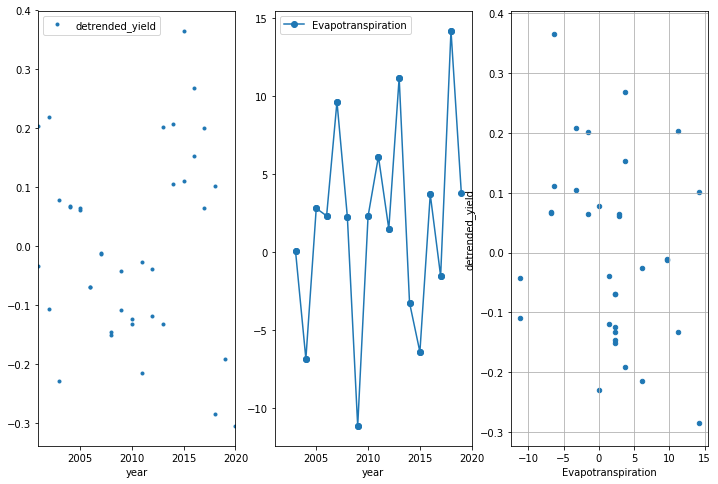

Barley
Evapotranspiration, 180-275


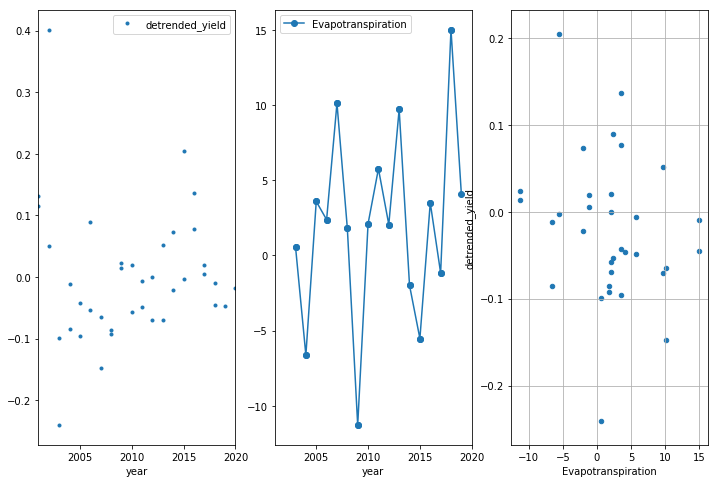

Sorghum
Evapotranspiration, 180-275


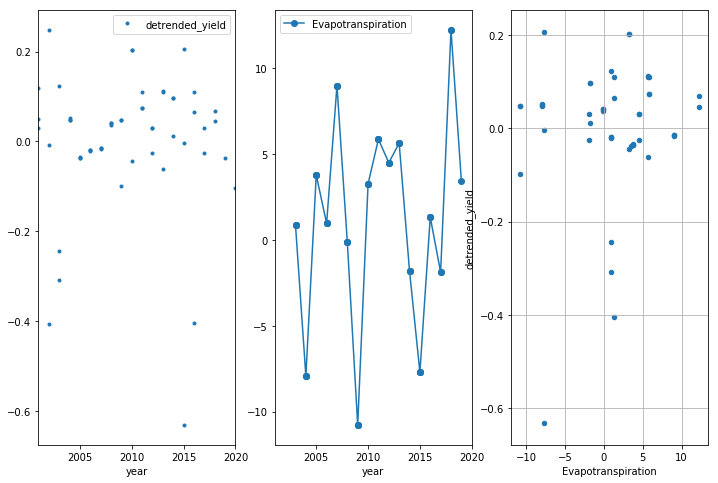

Small millet
Evapotranspiration, 180-275


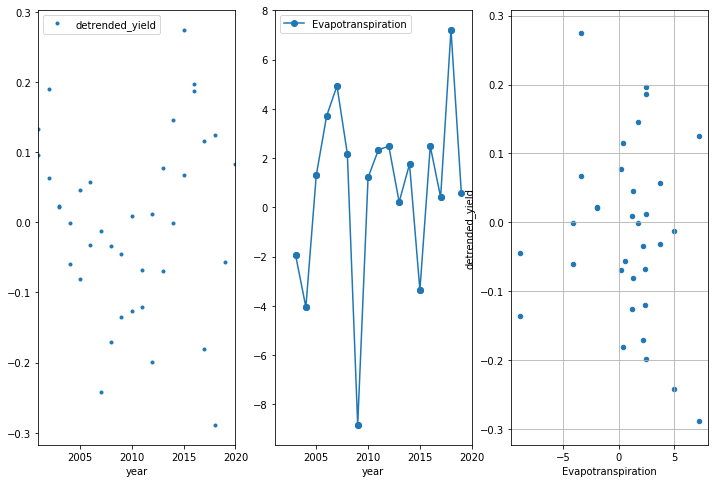

In [236]:
for crop in crops:
    print(crop)
    if crop == 'Small millet':
        y_df = dy_df['Millet']
    else:
        y_df = dy_df[crop]
    if y_df.empty:
        continue
    feat = get_feature(cw_eta_dfs[crop], 
                       "Evapotranspiration", 275,180,tol=10)
    show_feature(feat, y_df, "Evapotranspiration")

### NDVI
For NDVI, rather than the average or most recent value, the date of it's peak is found to be the strongest feature. The idea is that the relatively early or late occurence of  planting and growth is highly connected to conditions that ultimately affect yield. See e.g. [this paper](https://link.springer.com/article/10.1007/s10584-019-02432-7) which discuses such effects in 2015 in Ethiopia.

For example, let's look at how the timing of the peak of crop-weigthed NDVI between May and October relates to yield. 

Corn
Corn_ndvi, 135-303


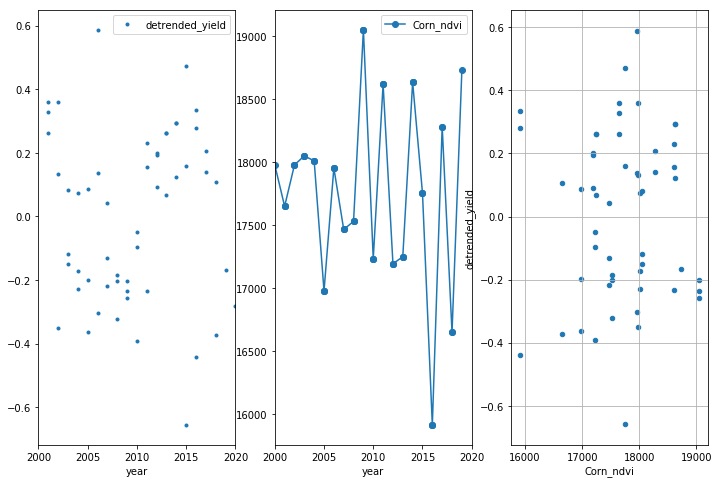

Wheat
Wheat_ndvi, 135-303


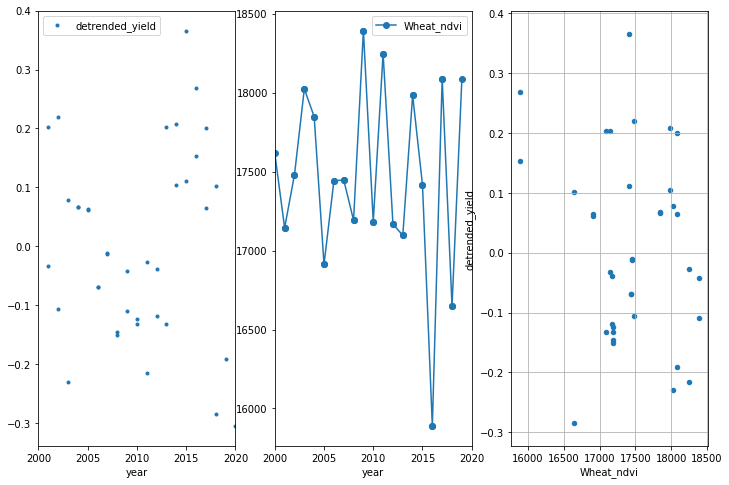

Barley
Barley_ndvi, 135-303


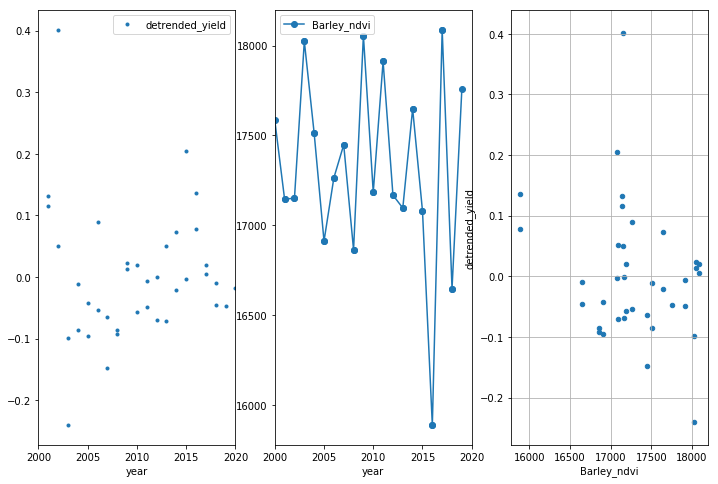

Sorghum
Sorghum_ndvi, 135-303


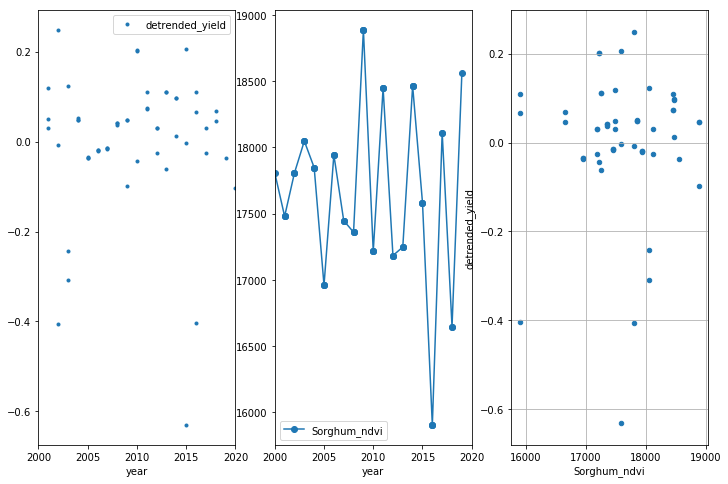

Small millet
Small millet_ndvi, 135-303


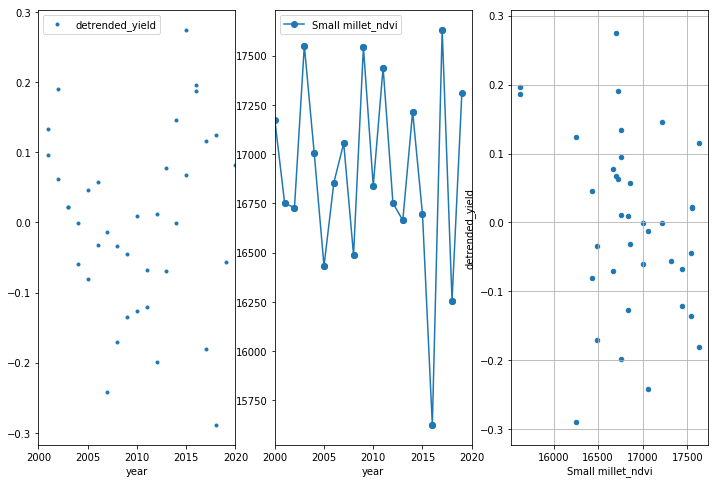

In [230]:
for crop in crops:
    print(crop)
    if crop == 'Small millet':
        y_df = dy_df['Millet']
    else:
        y_df = dy_df[crop]
    if y_df.empty:
        continue    
    feature = get_feature(cw_ndvi_dfs[crop],  "{}_ndvi".format(crop), 
                          doy=303, start_doy=135, tol=6, func=peak_day)
    show_feature(feature, y_df, "{}_ndvi".format(crop))

### Rainfall anomaly may-jul

In [ ]:
for crop in crops:
    print(crop)
    if crop == 'Small millet':
        y_df = dy_df['Millet']
    else:
        y_df = dy_df[crop]
    if y_df.empty:
        continue
    feat = get_feature(cw_rf_dfs[crop], 
                       "Rainfall",
                       "Precipitation difference from 10-yr mean (2001-2010)",
                        210, 120)
    show_feature(feat, y_df)

### Temperature jan-mar

In [ ]:
for crop in crops:
    print(crop)
    if crop == 'Small millet':
        y_df = dy_df['Millet']
    else:
        y_df = dy_df[crop]
    if y_df.empty:
        continue
    f_df = get_feature(cw_temp_dfs[crop], "Land temperature daytime", "Temperature", 79,1)
    show_feature(f_df, y_df)

## In-season yield model

We now fit a yield model to the above crop weighted features. The approach will give us a forecast for current year yields throughout the year. But we'll focus on a few key moments: end of March, end of June and end of Sept. 

A key aspect of our model is knowledge of growing seasons enabling us to focus the geospatial features on the most informative periods. For Ethiopia, using crop calendar information in Gro and infromation from [reports such as this one](http://www.fao.org/3/ak346e/ak346e00.htm), we choose to organize features into two seasons:  Belg (early March to mid-April) and Meher (mid-May through October).

In [261]:
import IPython
iframe="<iframe dropshadow=0 allowinteraction frameborder=0 width='640' height='600' src='https://app.gro-intelligence.com/#/embed/4LRy1byR3?chartId=aWQ9MzAxMzA3JnRpdGxlPXRydWUmbG9nbz10cnVlJmRpc3BsYXl0aXRsZT1FdGhpb3BpYSBjZXJlYWxz'></iframe>"
IPython.display.HTML(iframe)

In [86]:
START_BELG=60
END_BELG=105
START_MEHER=135
END_MEHER=303

lms_by_doy = {}

### Model training

Using features available as of day-of-year 91, 182, 273.

In [195]:
def show_results(lm_tuple, y_df=None):
    fig, axes = plt.subplots(1, 1)
    lm_tuple[3].plot(x='year', y='lm_yield', ax=axes)
    if y_df is not None:
        y_df.plot(x='year', y='detrended_yield', ax=axes, marker='o', linestyle='')
    plt.grid(b=True, which='both')
    plt.show()
    print('''RMSE: {} R2: {}\n'''.format(lm_tuple[1], lm_tuple[2]))

In [ ]:
import numpy
import math
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

def train_model(doy, crop):
    lms_by_doy.setdefault(doy, {})
    print('{} -- day of year: {}'.format(crop, doy))
    if crop == 'Small millet':
        y_df = dy_df['Millet']
    else:
        y_df = dy_df[crop]
    if y_df.empty:
        return

    lm = linear_model.LinearRegression()
    XY = pandas.DataFrame([{'year': year, 'detrended_yield': values['detrended_yield'].mean()}
                           for (year, values) in y_df.groupby(['year'])])
    features = [
        get_feature(cw_temp_dfs[crop], '{}_temp'.format(crop), 
                    doy=min(doy,END_MEHER), start_doy=1),
        get_feature(cw_ndvi_dfs[crop], '{}_ndvi_belg'.format(crop), 
                    doy=min(doy,END_BELG), start_doy=START_BELG, tol=7, func=peak_day),
        get_feature(cw_rf_dfs[crop], '{}_rain_belg'.format(crop), 
                    doy=min(doy,END_BELG), start_doy=START_BELG),
        get_feature(cw_eta_dfs[crop], '{}_et_belg'.format(crop),
                    doy=min(doy, END_BELG+15), start_doy=START_BELG+5, tol=20),
        get_feature(cw_ndvi_dfs[crop], '{}_ndvi_meher'.format(crop),
                    doy=min(doy, END_MEHER), start_doy=START_MEHER, tol=7, func=peak_day),
        get_feature(cw_rf_dfs[crop], '{}_rain_meher'.format(crop),
                    doy=min(doy, END_MEHER), start_doy=START_MEHER),
        get_feature(cw_eta_dfs[crop], '{}_et_meher'.format(crop),
                    doy=min(doy,END_MEHER), start_doy=START_MEHER, tol=27)
    ]
    for feature in filter(lambda f: not f.empty, features):
        XY = XY.merge(feature, on='year')
    feature_names = list(filter(lambda n: n not in ('year', 'detrended_yield'), XY.columns))

    lm.fit(XY.loc[:,feature_names], XY['detrended_yield'])

    lm_yield = lm.predict(XY.loc[:,feature_names])
    mse = mean_squared_error(XY['detrended_yield'], lm_yield)
    r2 = r2_score(XY['detrended_yield'], lm_yield)    
    lm_df = pandas.DataFrame([{'year': year, 'lm_yield': value} 
                              for (year, value) in zip(XY.year, lm_yield)])

    lms_by_doy[doy][crop] = (lm, math.sqrt(mse), r2, lm_df)
    
    show_results(lms_by_doy[doy][crop], y_df)

Corn -- day of year: 93
Corn_temp, 1-93
Corn_ndvi_belg, 60-93
Corn_rain_belg, 60-93
Corn_et_belg, 65-93
Corn_ndvi_meher, 135-93
Corn_rain_meher, 135-93
Corn_et_meher, 135-93


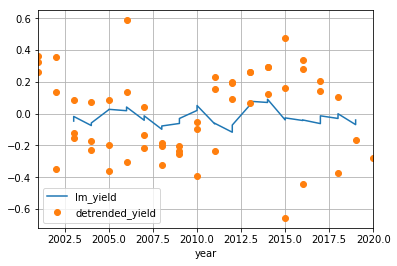

RMSE: 0.146012266883 R2: 0.111300759339

Wheat -- day of year: 93
Wheat_temp, 1-93
Wheat_ndvi_belg, 60-93
Wheat_rain_belg, 60-93
Wheat_et_belg, 65-93
Wheat_ndvi_meher, 135-93
Wheat_rain_meher, 135-93
Wheat_et_meher, 135-93


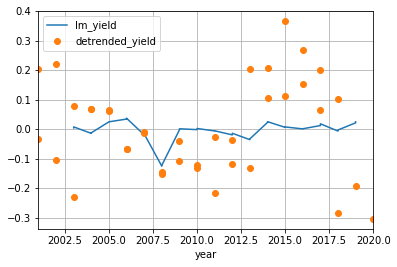

RMSE: 0.121965038536 R2: 0.0746521408796

Barley -- day of year: 93
Barley_temp, 1-93
Barley_ndvi_belg, 60-93
Barley_rain_belg, 60-93
Barley_et_belg, 65-93
Barley_ndvi_meher, 135-93
Barley_rain_meher, 135-93
Barley_et_meher, 135-93


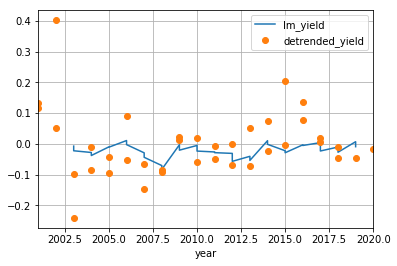

RMSE: 0.063122604515 R2: 0.106428748478

Sorghum -- day of year: 93
Sorghum_temp, 1-93
Sorghum_ndvi_belg, 60-93
Sorghum_et_belg, 65-93
Sorghum_ndvi_meher, 135-93
Sorghum_rain_meher, 135-93
Sorghum_et_meher, 135-93


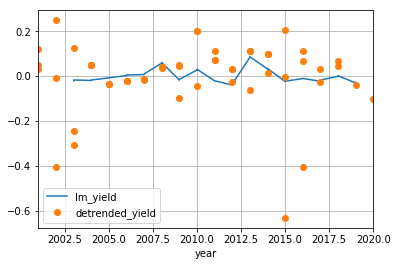

RMSE: 0.0638200634098 R2: 0.201245396897

Small millet -- day of year: 93
Small millet_temp, 1-93
Small millet_ndvi_belg, 60-93
Small millet_rain_belg, 60-93
Small millet_et_belg, 65-93
Small millet_ndvi_meher, 135-93
Small millet_rain_meher, 135-93
Small millet_et_meher, 135-93


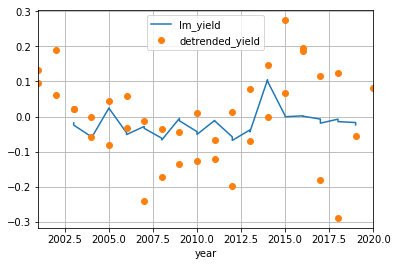

RMSE: 0.0798986383578 R2: 0.192247614048



In [244]:
for crop in crops:
    train_model(93, crop)

Corn -- day of year: 273
Corn_temp, 1-273
Corn_ndvi_belg, 60-105
Corn_rain_belg, 60-105
Corn_et_belg, 65-120
Corn_ndvi_meher, 135-273
Corn_rain_meher, 135-273
Corn_et_meher, 135-273


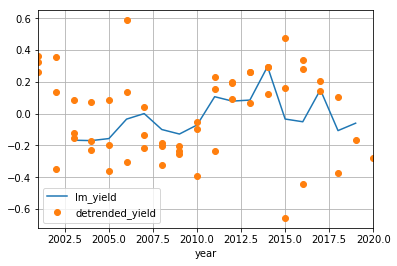

RMSE: 0.0932413917049 R2: 0.637595471242

Wheat -- day of year: 273
Wheat_temp, 1-273
Wheat_ndvi_belg, 60-105
Wheat_rain_belg, 60-105
Wheat_et_belg, 65-120
Wheat_ndvi_meher, 135-273
Wheat_rain_meher, 135-273
Wheat_et_meher, 135-273


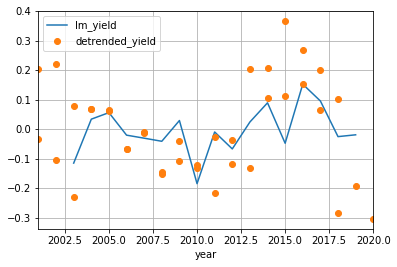

RMSE: 0.0997673001585 R2: 0.380828797271

Barley -- day of year: 273
Barley_temp, 1-273
Barley_ndvi_belg, 60-105
Barley_rain_belg, 60-105
Barley_et_belg, 65-120
Barley_ndvi_meher, 135-273
Barley_rain_meher, 135-273
Barley_et_meher, 135-273


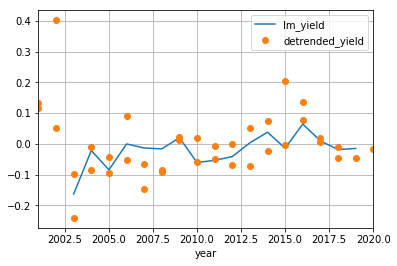

RMSE: 0.0448162700529 R2: 0.549566394261

Sorghum -- day of year: 273
Sorghum_temp, 1-273
Sorghum_ndvi_belg, 60-105
Sorghum_rain_belg, 60-105
Sorghum_et_belg, 65-120
Sorghum_ndvi_meher, 135-273
Sorghum_rain_meher, 135-273
Sorghum_et_meher, 135-273


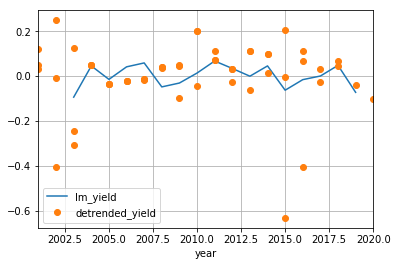

RMSE: 0.0529828196151 R2: 0.449485142278

Small millet -- day of year: 273
Small millet_temp, 1-273
Small millet_ndvi_belg, 60-105
Small millet_rain_belg, 60-105
Small millet_et_belg, 65-120
Small millet_ndvi_meher, 135-273
Small millet_rain_meher, 135-273
Small millet_et_meher, 135-273


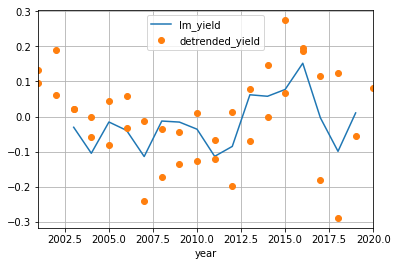

RMSE: 0.0516522591917 R2: 0.662418890141

Corn -- day of year: 182
Corn_temp, 1-182
Corn_ndvi_belg, 60-105
Corn_rain_belg, 60-105
Corn_et_belg, 65-120
Corn_ndvi_meher, 135-182
Corn_rain_meher, 135-182
Corn_et_meher, 135-182


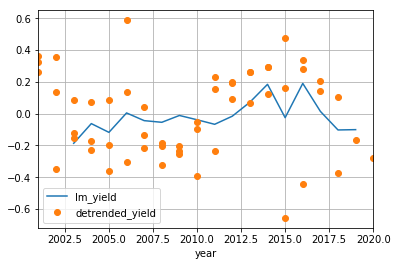

RMSE: 0.122443183089 R2: 0.375049896475

Wheat -- day of year: 182
Wheat_temp, 1-182
Wheat_ndvi_belg, 60-105
Wheat_rain_belg, 60-105
Wheat_et_belg, 65-120
Wheat_ndvi_meher, 135-182
Wheat_rain_meher, 135-182
Wheat_et_meher, 135-182


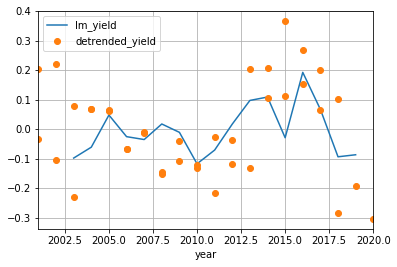

RMSE: 0.0959347921628 R2: 0.427485371593

Barley -- day of year: 182
Barley_temp, 1-182
Barley_ndvi_belg, 60-105
Barley_rain_belg, 60-105
Barley_et_belg, 65-120
Barley_ndvi_meher, 135-182
Barley_rain_meher, 135-182
Barley_et_meher, 135-182


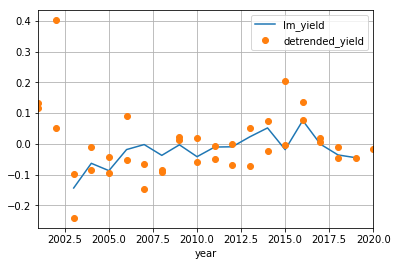

RMSE: 0.0455554112527 R2: 0.534586141526

Sorghum -- day of year: 182
Sorghum_temp, 1-182
Sorghum_ndvi_belg, 60-105
Sorghum_rain_belg, 60-105
Sorghum_et_belg, 65-120
Sorghum_ndvi_meher, 135-182
Sorghum_rain_meher, 135-182
Sorghum_et_meher, 135-182


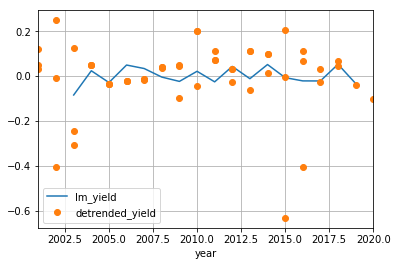

RMSE: 0.0611600040339 R2: 0.26644290495

Small millet -- day of year: 182
Small millet_temp, 1-182
Small millet_ndvi_belg, 60-105
Small millet_rain_belg, 60-105
Small millet_et_belg, 65-120
Small millet_ndvi_meher, 135-182
Small millet_rain_meher, 135-182
Small millet_et_meher, 135-182


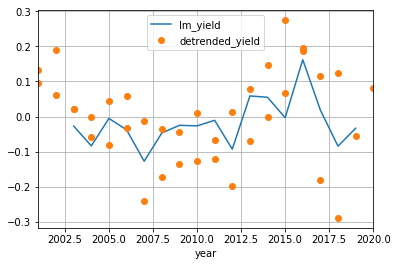

RMSE: 0.0599324403824 R2: 0.545510957096

Corn -- day of year: 91
Corn_temp, 1-91
Corn_ndvi_belg, 60-91
Corn_rain_belg, 60-91
Corn_et_belg, 65-91
Corn_ndvi_meher, 135-91
Corn_rain_meher, 135-91
Corn_et_meher, 135-91


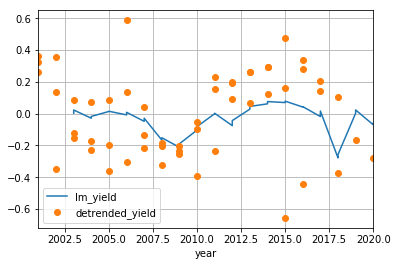

RMSE: 0.134083976931 R2: 0.313776233435

Wheat -- day of year: 91
Wheat_temp, 1-91
Wheat_ndvi_belg, 60-91
Wheat_rain_belg, 60-91
Wheat_et_belg, 65-91
Wheat_ndvi_meher, 135-91
Wheat_rain_meher, 135-91
Wheat_et_meher, 135-91


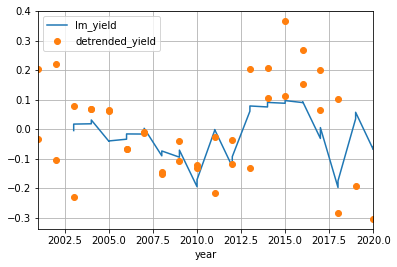

RMSE: 0.113614062647 R2: 0.351225899679

Barley -- day of year: 91
Barley_temp, 1-91
Barley_ndvi_belg, 60-91
Barley_rain_belg, 60-91
Barley_et_belg, 65-91
Barley_ndvi_meher, 135-91
Barley_rain_meher, 135-91
Barley_et_meher, 135-91


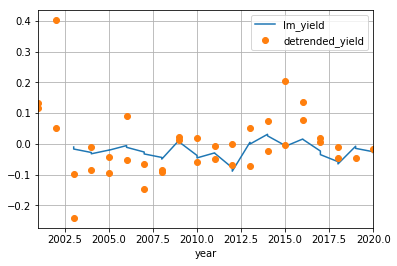

RMSE: 0.0591469067509 R2: 0.169439626242

Sorghum -- day of year: 91
Sorghum_temp, 1-91
Sorghum_ndvi_belg, 60-91
Sorghum_rain_belg, 60-91
Sorghum_et_belg, 65-91
Sorghum_ndvi_meher, 135-91
Sorghum_rain_meher, 135-91
Sorghum_et_meher, 135-91


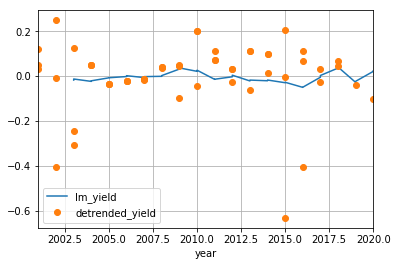

RMSE: 0.0699277460373 R2: 0.0925010987955

Small millet -- day of year: 91
Small millet_temp, 1-91
Small millet_ndvi_belg, 60-91
Small millet_rain_belg, 60-91
Small millet_et_belg, 65-91
Small millet_ndvi_meher, 135-91
Small millet_rain_meher, 135-91
Small millet_et_meher, 135-91


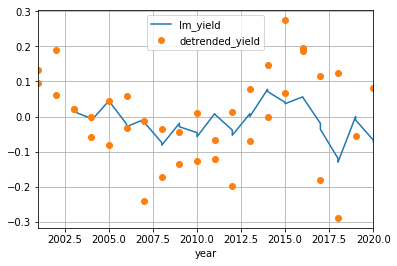

RMSE: 0.0747273259758 R2: 0.301643048813



In [116]:
import numpy
import math
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

for doy in (273,182,91):
    for crop in crops:
        train_model(doy, crop)

# Performance Summary

In-sample fit statistics

In [254]:
header = 'Day of year'
for doy in sorted(lms_by_doy.keys()):
    header += '\t{}\t'.format(doy)
print(header +'\n------')
df = model.get_df()

for item_id, XY in df.loc[df.metric_id == yield_metric_id].groupby(['item_id']):
    crop = model.lookup('items', item_id)['name']
    if crop == 'Millet':
        crop = 'Small millet'
    if crop not in crops:
        continue
    row='{:8}'.format(crop)
    for lm in [lms_by_doy[doy].get(crop,(None,numpy.nan,numpy.nan)) for doy in sorted(lms_by_doy.keys())]:
        row += '\t{:4.1f}%\t{:4.1f}%|'.format(100*lm[1]/XY.value.mean(),100*lm[2])
    print(row)

Day of year	99		182		273	
------
Barley  	 5.2%	13.7%|	 3.8%	53.5%|	 3.4%	59.2%|
Small millet	 8.6%	16.6%|	 6.0%	54.6%|	 5.1%	66.2%|
Wheat   	 9.0%	 7.1%|	 7.3%	42.7%|	 7.6%	38.1%|
Corn    	 7.9%	22.7%|	 6.7%	37.5%|	 5.1%	63.8%|
Sorghum 	 4.7%	16.6%|	 4.4%	26.6%|	 3.8%	44.9%|


# Forecast for 2020

In [119]:
def predict(crop, DOY, YEAR):
    print(crop)
    X = get_feature(cw_temp_dfs[crop], 'temp', doy=DOY, start_doy=1, year=YEAR)
    X = X.merge(get_feature(cw_ndvi_dfs[crop], 'ndvi1', 
                    doy=DOY - DOY%8, start_doy=START_BELG, func=peak_day, year=YEAR), on='year')
    X = X.merge(get_feature(cw_rf_dfs[crop], 'rain1', doy=DOY, start_doy=START_BELG, year=YEAR), on='year')
    X = X.merge(get_feature(cw_eta_dfs[crop], 'et1', doy=DOY, start_doy=START_BELG, year=YEAR), on='year')
    X = X.merge(get_feature(cw_ndvi_dfs[crop], 'ndvi2',
                        doy=min(DOY, END_MEHER), start_doy=START_MEHER,func=peak_day, year=YEAR), on='year')
    X = X.merge(get_feature(cw_rf_dfs[crop], 'rain2',
                        doy=min(DOY, END_MEHER), start_doy=START_MEHER, year=YEAR), on='year')
    X = X.merge(get_feature(cw_eta_dfs[crop], 'et2',
                        doy=min(DOY,END_MEHER), start_doy=START_MEHER,year=YEAR), on='year')

    feature_names = list(filter(lambda n: n not in ('year'), X.columns))
    lm_yield = lms_by_doy[DOY][crop][0].predict(X.loc[X.year == YEAR, feature_names])[0]
    if crop == 'Small millet':
        trend_yield = trends['Millet'].predict([[YEAR]])[0]
    else:
        trend_yield = trends[crop].predict([[YEAR]])[0]
    print('{:.2f} + {:.2f} = {:.2f} +/- {:.2f} t/ha\n'.format(
        lm_yield, trend_yield, lm_yield + trend_yield, lms_by_doy[DOY][crop][1]/2.0))

for crop in crops:
    predict(crop=crop, DOY=91, YEAR=2020)

Corn
cw_temp, 1-91
belg_ndvi, 60-88
belg_r, 60-91
belg_et, 60-91
meher_ndvi, 135-91
meher_r, 135-91
meher_et, 135-91
-0.06 + 3.93 = 3.87 +/- 0.07 t/ha

Wheat
cw_temp, 1-91
belg_ndvi, 60-88
belg_r, 60-91
belg_et, 60-91
meher_ndvi, 135-91
meher_r, 135-91
meher_et, 135-91
-0.02 + 2.89 = 2.88 +/- 0.06 t/ha

Barley
cw_temp, 1-91
belg_ndvi, 60-88
belg_r, 60-91
belg_et, 60-91
meher_ndvi, 135-91
meher_r, 135-91
meher_et, 135-91
-0.01 + 2.32 = 2.31 +/- 0.03 t/ha

Sorghum
cw_temp, 1-91
belg_ndvi, 60-88
belg_r, 60-91
belg_et, 60-91
meher_ndvi, 135-91
meher_r, 135-91
meher_et, 135-91
0.02 + 2.84 = 2.86 +/- 0.03 t/ha

Small millet
cw_temp, 1-91
belg_ndvi, 60-88
belg_r, 60-91
belg_et, 60-91
meher_ndvi, 135-91
meher_r, 135-91
meher_et, 135-91
-0.08 + 2.36 = 2.28 +/- 0.04 t/ha



## Notes

2009 was a low yield year for wheat, corn and small millet in 2009, normal for barley and sorghum

http://www.fao.org/3/ak346e/ak346e00.htm

- 2009 poor secondary season “belg” rains (February-May) followed by late meher rains
- all crops harvested by 31 August are regarded as ‘belg’ crops, while crops harvested from 1 September to 31 March are regarded as ‘meher’ crops. 
- Traditionally, the belg production supplies about 8 percent of annual national crop production. 
- estimated 2009 belg crop production at ....  about 4.8 percent of the overall 2009 production. 
- the meher rainfall only began between the last week of June and mid-July instead of its normal start at the end of May/beginning of June. 
- As an example, the normal onset of the meher rains in Adigrat (eastern Tigray) takes place in the first week of June and the rains usually cease around September 20. In 2009, the meher rains began on June 22 and ended on August 22, almost a month too soon.  

Rain:
- belg: march-apr
- kremt/meher: june-sep

ET anomaly
https://www.sciencedirect.com/science/article/pii/S0303243415000604

- use ET anomaly for  season (May–October).
- spatial variaton in feature importance https://www.sciencedirect.com/science/article/pii/S0303243415000604#tbl0025
- 2014 was a high yield year for all 5 crops. Rainfall quantity and distribution during the 2014 meher season was favorable, as summarized by the cumulative Evapo-transpiration Anomaly (ETa) product (Figure 3).https://ipad.fas.usda.gov/highlights/2015/01/Ethiopia/Index.htm

Temperature
-  2018 low yield esp for wheat and small millet
- 2018 temp low

https://link.springer.com/article/10.1007/s10584-019-02432-7 
- date of ndvi max is key feature
- seems to say 2015 was a bad year for all crops... imho later crop losses might be exaggerated 
  - 2015 high yields for barlet, wheat small millet 
  - 2015 ground truth divergence for corn and sorghum between fao/igc/psd
- crops planted earlier in the season (February for maize and sorghum) ... planted late in the season (May for barley, teff, and wheat)

- two ndvi peaks for barley, wheat


In [256]:
model.get_df().shape

(1411866, 13)

In [259]:
import pickle
with open('ethiopia_cereals.data', 'wb') as dump_file:
    pickle.dump(model.get_df(), dump_file)